# SERIES TEMPORALES

# Dataset Radiacion UVA

### Autor: Francisco Guasumba

In [1]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
# !pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
#!pip install skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import warnings

import statsmodels.api as sm


In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.resetwarnings()

### Carga Dataset

In [3]:
#carga dataset
df = pd.read_csv(r"D:\UCM\MINERIA 4\Datasets\SOLAR\RAD-PLAZA_ELIPTICA_V2.csv",sep=',')

In [4]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5509 entries, 0 to 5508
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            5509 non-null   int64  
 1   MO              5509 non-null   int64  
 2   DY              5509 non-null   int64  
 3   ALLSKY_SFC_UVA  5509 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 172.3 KB


,YEAR,MO,DY,ALLSKY_SFC_UVA
0,2009,1,1,3.17
1,2009,1,2,3.95
2,2009,1,3,1.33
3,2009,1,4,4.90
4,2009,1,5,3.02
...,...,...,...,...
5504,2024,1,27,-999.00
5505,2024,1,28,-999.00
5506,2024,1,29,-999.00
5507,2024,1,30,-999.00


In [5]:
#transformacion de Indice
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MO'].astype(str) + '-' + df['DY'].astype(str))
df.set_index('DATE', inplace=True)

# Eliminar las columnas antiguas, cambio de nombre

df.drop(['YEAR', 'MO', 'DY'], axis=1, inplace=True)
df.rename(columns={'ALLSKY_SFC_UVA': 'UVA'}, inplace=True)
#seleccion de valores válidos

mascara = (df['UVA']!=-999) 
df = df[mascara]
df

,UVA
DATE,
2009-01-01,3.17
2009-01-02,3.95
2009-01-03,1.33
2009-01-04,4.90
2009-01-05,3.02
...,...
2023-10-28,5.45
2023-10-29,4.02
2023-10-30,6.70


In [6]:
#descriptibos
df.describe()

,UVA
count,5418.000000
mean,11.224969
std,5.640351
min,1.110000
25%,5.890000
50%,10.960000
75%,16.470000
max,21.270000


In [7]:
#valores nulos
df.isna().sum()

UVA    0
dtype: int64

In [8]:
#datos.info()

### Estacionalidad Tendencia

In [9]:
#frecuancia modelo MS meses , particion de datos 
df = df.asfreq('MS')
datos= df.copy()
datos = datos.loc[:'2022-01-01']
# se comprueba lo predicho con los valores reales
datos_futuro = df.loc['2022-01-01':'2023-12-31']

In [10]:
print(datos_futuro)

              UVA
DATE             
2022-01-01   4.98
2022-02-01   7.34
2022-03-01  10.11
2022-04-01  12.69
2022-05-01  16.47
2022-06-01  20.09
2022-07-01  20.71
2022-08-01  17.90
2022-09-01  15.79
2022-10-01  11.98
2022-11-01   6.70
2022-12-01   5.48
2023-01-01   3.91
2023-02-01   7.22
2023-03-01   7.87
2023-04-01  12.29
2023-05-01  18.05
2023-06-01  12.14
2023-07-01  20.48
2023-08-01  19.63
2023-09-01  14.65
2023-10-01  12.26
2023-11-01   3.55


Text(0.5, 1.0, 'Serie original')

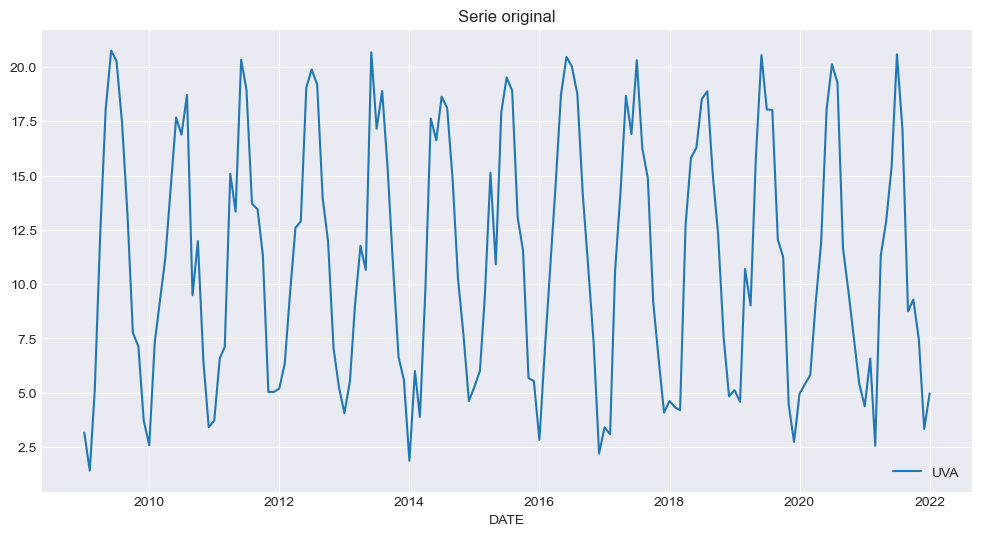

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(datos)
plt.title("Serie original")

Text(0.5, 1.0, 'Serie diferenciada de orden 1')

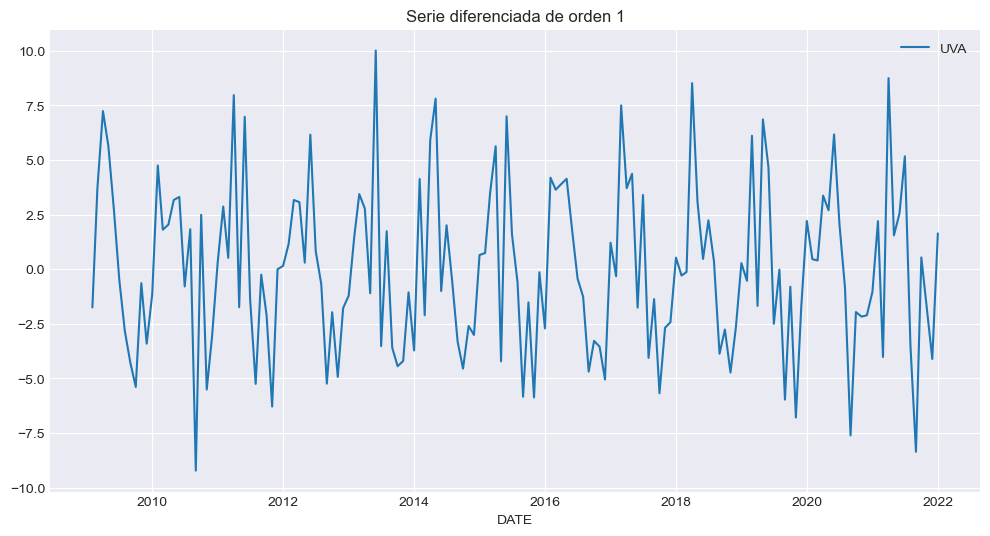

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(datos.diff())
plt.title("Serie diferenciada de orden 1")

In [13]:
#Pruebas de estacionariedad

datos_diff_1 = datos.diff(1).dropna()
print('Test estacionariedad serie original')
print(f'ADF Statistic: {adfuller(datos)[0]}, p-value: {adfuller(datos)[1]}')
print(f'KPSS Statistic: {kpss(datos)[0]}, p-value: {kpss(datos)[1]}')
print('\nTest estacionariedad serie diferenciada de orden 1')
print(f'ADF Statistic: {adfuller(datos_diff_1)[0]}, p-value: {adfuller(datos_diff_1)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1)[0]}, p-value: {kpss(datos_diff_1)[1]}')

Test estacionariedad serie original
ADF Statistic: -1.7595799383590403, p-value: 0.40070561342782707
KPSS Statistic: 0.025620912506969688, p-value: 0.1

Test estacionariedad serie diferenciada de orden 1
ADF Statistic: -9.480978907939118, p-value: 3.8736422773294873e-16
KPSS Statistic: 0.02638586078175822, p-value: 0.1


C:\Users\franc\AppData\Local\Temp\ipykernel_5380\2503909879.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos)[0]}, p-value: {kpss(datos)[1]}')
C:\Users\franc\AppData\Local\Temp\ipykernel_5380\2503909879.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos)[0]}, p-value: {kpss(datos)[1]}')
C:\Users\franc\AppData\Local\Temp\ipykernel_5380\2503909879.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos_diff_1)[0]}, p-value: {kpss(datos_diff_1)[1]}')
C:\Users\franc\AppData\Local\Temp\ipykernel_5380\2503909879.py:9: Inter

In [14]:
#descomposicion aditiva
result = seasonal_decompose(datos['UVA'], model='add')

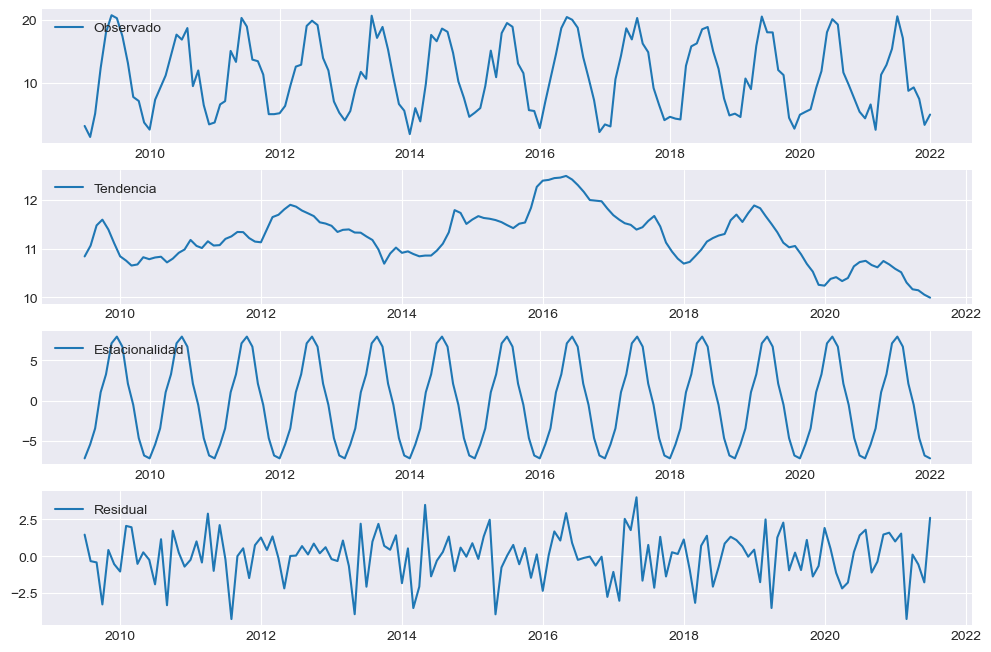

In [15]:

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal,
label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid,
label='Residual')
plt.legend(loc='upper left')
plt.show()

In [16]:
len(datos_futuro)

23

## Modelos Holt winters

In [17]:
# Aplicar suavizado Holt-Winters. Con tendendia trend 
modelo_holt_winters = sm.tsa.ExponentialSmoothing(datos, trend='add',seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw = modelo_holt_winters.forecast(steps=23)
# Mostrar la descripción del modelo
modelo_holt_winters.summary()

Dep. Variable:,UVA,No. Observations:,157
Model:,ExponentialSmoothing,SSE,499.484
Optimized:,True,AIC,213.701
Trend:,Additive,BIC,262.601
Seasonal:,Additive,AICC,218.657
Seasonal Periods:,12,Date:,"Thu, 08 Feb 2024"
Box-Cox:,False,Time:,22:10:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0407260,alpha,True
smoothing_trend,0.0407260,beta,True


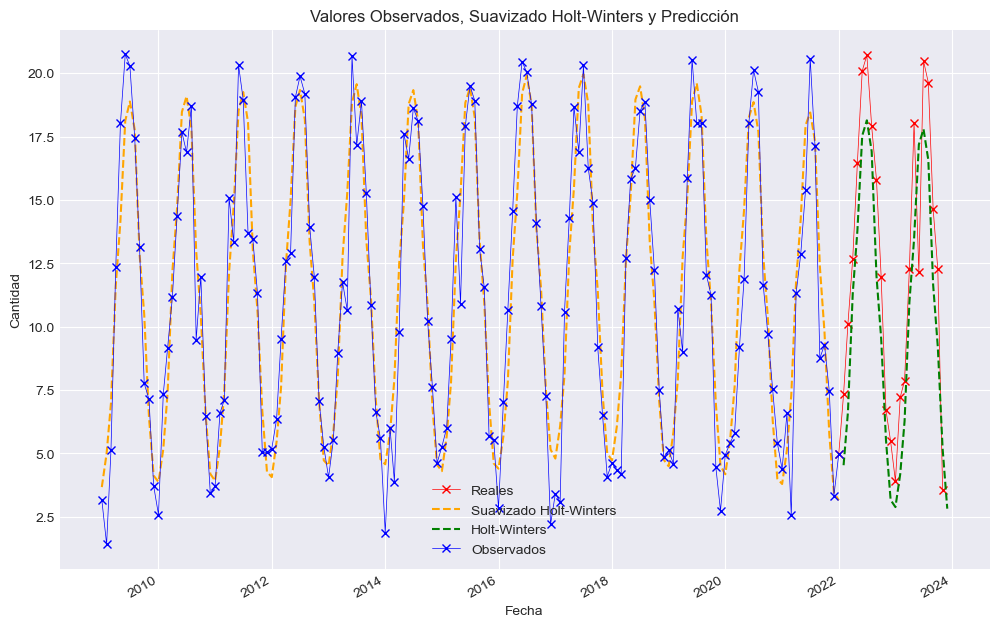

In [18]:
# Crear un gráfico con matplotlib
plt.figure(figsize=(12, 7))

plt.plot(datos_futuro.index, datos_futuro, label='Reales', marker='x', linestyle='-', color='red',linewidth = '0.5')
plt.plot(datos.index, modelo_holt_winters.fittedvalues, label='Suavizado Holt-Winters', linestyle='--', color='orange')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='green')
plt.plot(datos.index, datos, label='Observados', marker='x', linestyle='-', color='blue',linewidth = '0.5')

plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Valores Observados, Suavizado Holt-Winters y Predicción')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

In [19]:
# Aplicar suavizado Holt-Winters. AÑadimos beta = la importanciade la pendiente #para datos sin estacionalidad.
modelo_holt_winters = sm.tsa.ExponentialSmoothing(datos, trend=None,seasonal='additive', seasonal_periods=12).fit()
# Obtener predicciones para 1 año
predicciones_hw = modelo_holt_winters.forecast(steps=23)
# Mostrar la descripción del modelo
modelo_holt_winters.summary()

Dep. Variable:,UVA,No. Observations:,157
Model:,ExponentialSmoothing,SSE,495.065
Optimized:,True,AIC,208.306
Trend:,None,BIC,251.093
Seasonal:,Additive,AICC,212.191
Seasonal Periods:,12,Date:,"Thu, 08 Feb 2024"
Box-Cox:,False,Time:,22:10:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_seasonal,0.000000,gamma,True


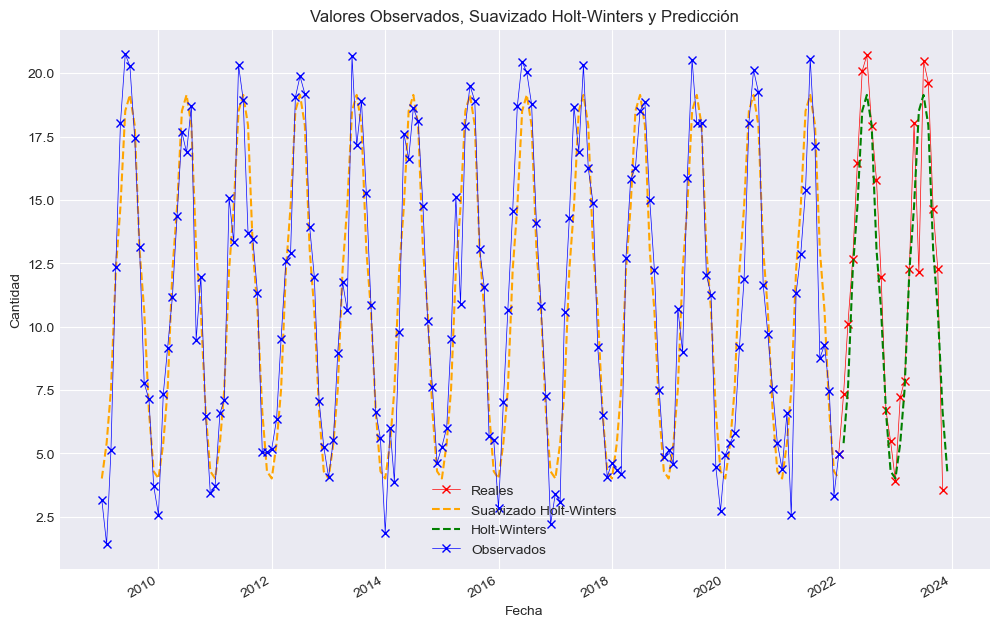

In [20]:
# Crear un gráfico con matplotlib
plt.figure(figsize=(12, 7))

plt.plot(datos_futuro.index, datos_futuro, label='Reales', marker='x', linestyle='-', color='red',linewidth = '0.5')
plt.plot(datos.index, modelo_holt_winters.fittedvalues, label='Suavizado Holt-Winters', linestyle='--', color='orange')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--',color='green')
plt.plot(datos.index, datos, label='Observados', marker='x', linestyle='-', color='blue',linewidth = '0.5')

plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Valores Observados, Suavizado Holt-Winters y Predicción')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

## Modelos Arima

In [21]:
#SERIE Diferenciada a 12 anual.
datos_diff_1_12 = datos_diff_1.diff(12).dropna()
print('Test estacionariedad serie de orden 12')
print('\nTest estacionariedad serie diferenciada de orden 12')
print(f'ADF Statistic: {adfuller(datos_diff_1_12)[0]}, p-value: {adfuller(datos_diff_1_12)[1]}')
print(f'KPSS Statistic: {kpss(datos_diff_1_12)[0]}, p-value: {kpss(datos_diff_1_12)[1]}')

Test estacionariedad serie de orden 12

Test estacionariedad serie diferenciada de orden 12
ADF Statistic: -5.906172408313048, p-value: 2.705383967710235e-07
KPSS Statistic: 0.029194273841339477, p-value: 0.1


C:\Users\franc\AppData\Local\Temp\ipykernel_5380\1590663351.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos_diff_1_12)[0]}, p-value: {kpss(datos_diff_1_12)[1]}')
C:\Users\franc\AppData\Local\Temp\ipykernel_5380\1590663351.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS Statistic: {kpss(datos_diff_1_12)[0]}, p-value: {kpss(datos_diff_1_12)[1]}')


Text(0.5, 1.0, 'Autoorrelación parcial serie diferenciada (order=1) PACF')

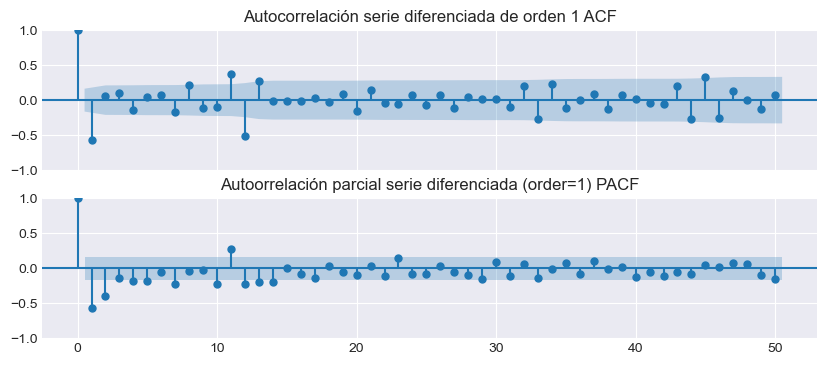

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), sharex=True)
plot_acf(datos_diff_1_12, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie diferenciada de orden 1 ACF')
plot_pacf(datos_diff_1_12, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1) PACF')

## Modelo Sarimax

In [23]:
#(2,1,1) (0,1,0,12)

In [24]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo = SARIMAX(endog = datos, order = (2,1,1), seasonal_order = (0,1,0,12))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 UVA   No. Observations:                  157
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -340.070
Date:                             Thu, 08 Feb 2024   AIC                            688.140
Time:                                     22:10:15   BIC                            700.019
Sample:                                 01-01-2009   HQIC                           692.967
                                      - 01-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0925      0.079     -1.165      0.244      -0.248       0.063
ar.L2          0.0645      0.086      0.749      0.454      -0.104       0.233
ma.L1         -0.9995      0.882     -1.134      0.257      -2.727       0.728
sigma2         6.3649      5.537      1.150      0.250      -4.487      17.217
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.20
Prob(Q):                              0.88   Prob(JB):                         0.04
Heteroskedasticity (H):               1.05   Skew:                             0.33
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox
estadistico_lb, p_valor_lb = acorr_ljungbox(modelo_res.resid, lags=[12])

In [26]:
# Predicción
# ==============================================================================
predicciones_statsmodels = modelo_res.get_forecast(steps=23).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(8))

2022-02-01     6.319938
2022-03-01     2.552289
2022-04-01    11.223492
2022-05-01    12.797051
2022-06-01    15.339792
2022-07-01    20.511982
2022-08-01    17.041311
2022-09-01     8.681515
Freq: MS, Name: predicciones_statsmodels, dtype: float64

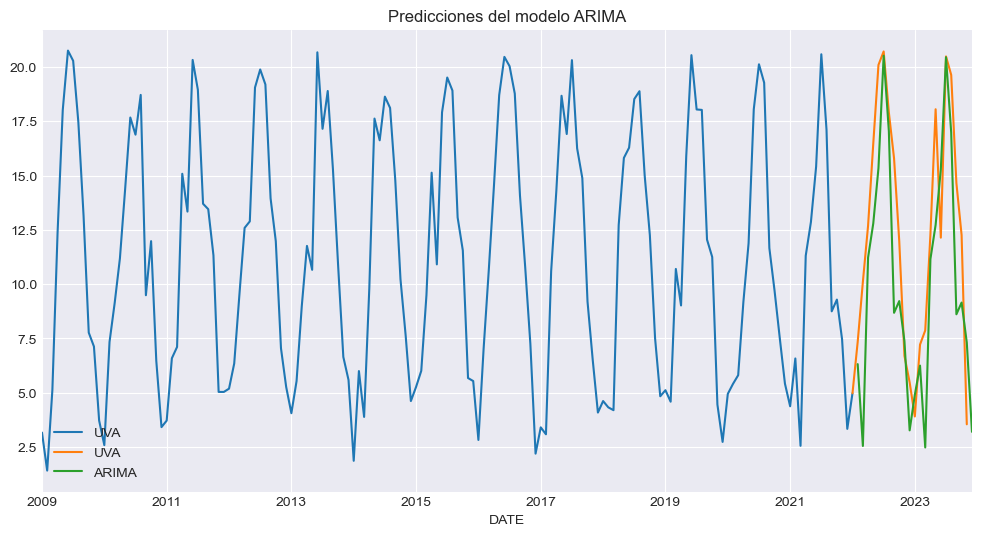

In [27]:
# Plot predictions
fig, ax = plt.subplots(figsize=(12, 6))
datos.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

In [28]:
# Mean Squared Error (MSE)
mse = mean_squared_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 22.012506860192108
Root Mean Squared Error (RMSE): 4.691748806169413
Mean Absolute Error (MAE): 3.6587159233249276


## Intervalo de confianza

In [29]:
#intervalo de confianza
pred =  modelo_res.get_forecast(steps=23)
confianza = pred.conf_int(alpha=0.05)


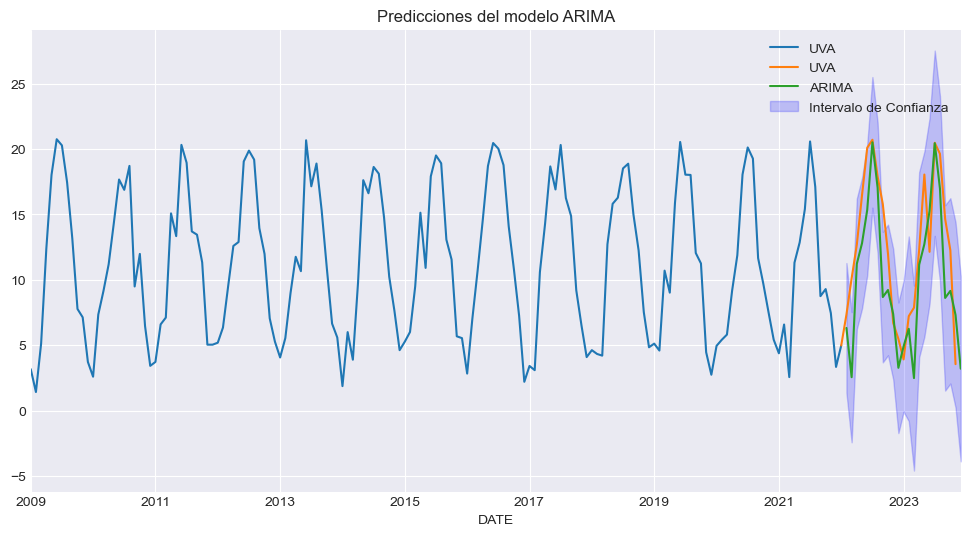

In [30]:
# Plot predictions
fig, ax = plt.subplots(figsize=(12, 6))
datos.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.fill_between(predicciones_statsmodels.index, confianza.iloc[:,0],confianza.iloc[:,1], color='blue', alpha=0.2, label='Intervalo de Confianza')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

In [31]:
#(datos_futuro['UVA'] - predicciones_statsmodels).head(5)

In [32]:
confianza.head(5)

,lower UVA,upper UVA
2022-02-01,1.359466,11.280410
2022-03-01,-2.426208,7.530785
2022-04-01,6.229589,16.217395
2022-05-01,7.803170,17.790932
2022-06-01,10.345632,20.333951


## Autoarima

In [33]:
#(p,d,q)(P,D,Q,m)
#(2,1,1) (0,1,0,12)

In [34]:
modelo = auto_arima(
            y                 = datos,
            start_p           = 0,
            start_q           = 0,
            max_p             = 3,
            max_q             = 3,
            seasonal          = True,
            test              = 'adf',
            m                 = 12, # periodicidad de la estacionalidad
            d                 = 1, # El algoritmo determina 'd'
            D                 = 1, # El algoritmo determina 'D'
            trace             = True,
            error_action      = 'ignore',
            suppress_warnings = True,
            stepwise          = True
        )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=793.465, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=698.289, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=736.269, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=687.483, Time=0.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.22 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=729.483, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=672.021, Time=0.28 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=679.157, Time=0.13 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=671.768, Time=0.49 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=678.698, Time=

In [35]:
# Modelo SARIMAX con statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo_final = SARIMAX(endog = datos, order = (0,1,1), seasonal_order = (2,1,1,12))
modelo_final_res = modelo_final.fit(disp=0)
warnings.filterwarnings("default")
modelo_final_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                UVA   No. Observations:                  157
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -310.975
Date:                            Thu, 08 Feb 2024   AIC                            631.949
Time:                                    22:10:51   BIC                            646.798
Sample:                                01-01-2009   HQIC                           637.983
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9455      0.044    -21.474      0.000      -1.032      -0.859
ar.S.L12       0.0058      0.132      0.044      0.965      -0.253       0.265
ar.S.L24       0.0025      0.110      0.022      0.982      -0.213       0.218
ma.S.L12      -0.9990     23.461     -0.043      0.966     -46.981      44.983
sigma2         3.4749     81.202      0.043      0.966    -155.678     162.628
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.78
Prob(Q):                              0.93   Prob(JB):                         0.09
Heteroskedasticity (H):               1.10   Skew:                            -0.41
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
predicciones_statsmodels_fin = modelo_final_res.get_forecast(steps=23).predicted_mean

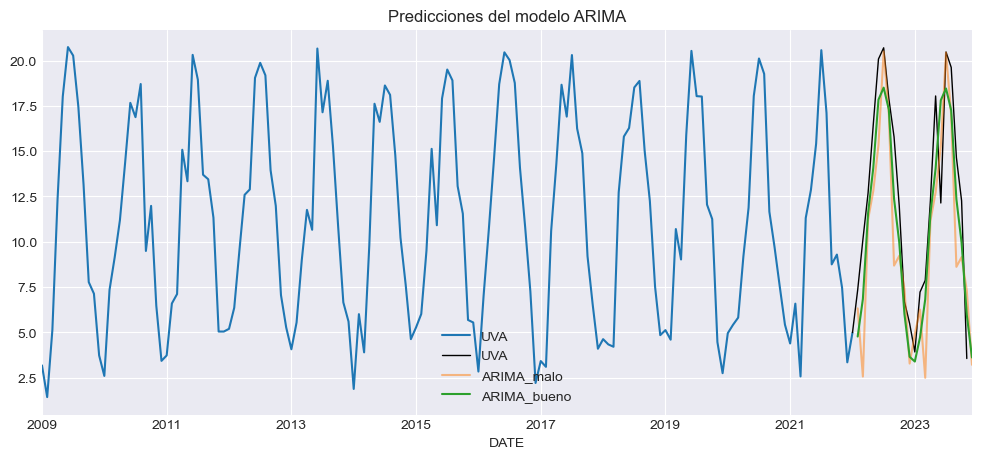

In [37]:
# Plot predictions
fig, ax = plt.subplots(figsize=(12, 5))
datos.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales',color='black',linewidth = 1)
predicciones_statsmodels.plot(ax=ax, label='ARIMA_malo',alpha= 0.5)
predicciones_statsmodels_fin.plot(ax=ax, label='ARIMA_bueno')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

In [38]:
# Mean Squared Error (MSE)
mse = mean_squared_error(datos_futuro, predicciones_statsmodels_fin)
print(f'Mean Squared Error (MSE): {mse}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(datos_futuro, predicciones_statsmodels_fin)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 13.783315043434369
Root Mean Squared Error (RMSE): 3.7125887253282404
Mean Absolute Error (MAE): 2.920917022599755


## Intervalo de confianza


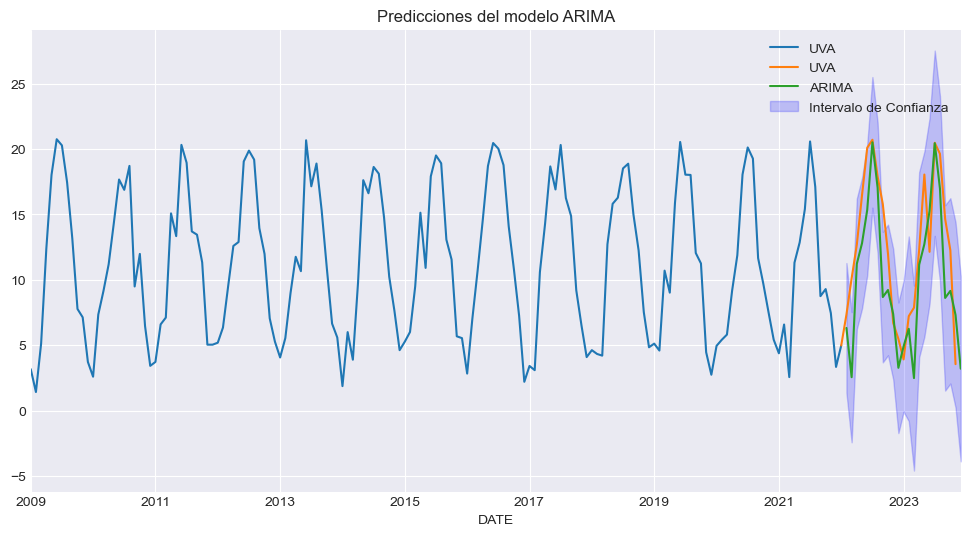

In [39]:
#intervalo de confianza
pred_fin =  modelo_res.get_forecast(steps=23)
confianza_fin = pred.conf_int(0.05)

# Plot predictions
fig, ax = plt.subplots(figsize=(12, 6))
datos.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.fill_between(predicciones_statsmodels.index, confianza_fin.iloc[:,0],confianza_fin.iloc[:,1], color='blue', alpha=0.2, label='Intervalo de Confianza')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend();

In [40]:
confianza_fin.head(5)

,lower UVA,upper UVA
2022-02-01,1.359466,11.280410
2022-03-01,-2.426208,7.530785
2022-04-01,6.229589,16.217395
2022-05-01,7.803170,17.790932
2022-06-01,10.345632,20.333951
